# Import dependencies

In [15]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [16]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

           Date                Country Province  Infected  Deaths  Recovered
7308 2020-03-20                 Jersey        -         0       0          0
7309 2020-03-20            Puerto Rico        -         0       0          0
7310 2020-03-20  Republic of the Congo        -         0       0          0
7311 2020-03-20            The Bahamas        -         0       0          0
7312 2020-03-20             The Gambia        -         0       0          0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7313 entries, 0 to 7312
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7313 non-null   datetime64[ns]
 1   Country    7313 non-null   object        
 2   Province   7313 non-null   object        
 3   Infected   7313 non-null   int64         
 4   Deaths     7313 non-null   int64         
 5   Recovered  7313 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory us

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

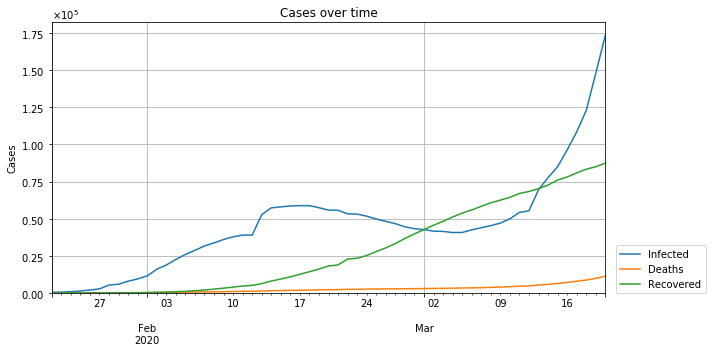

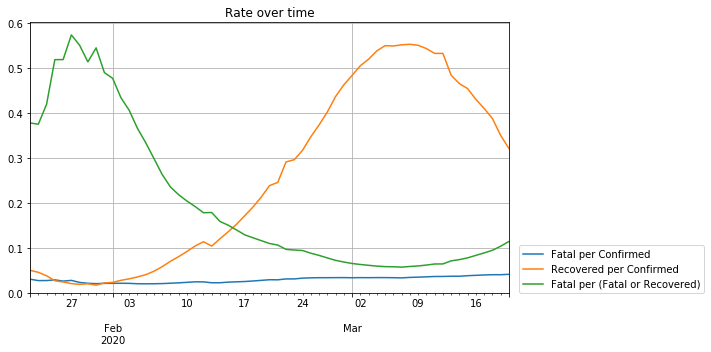

In [17]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

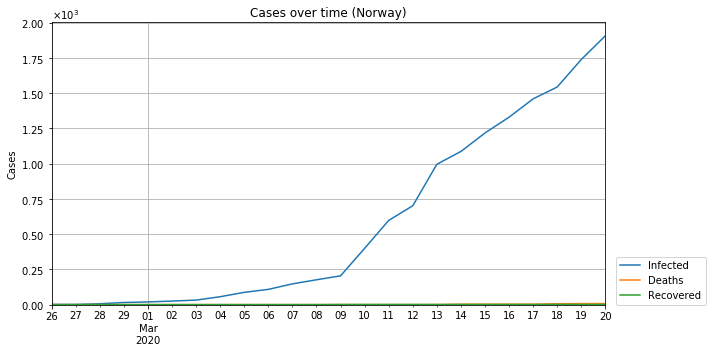

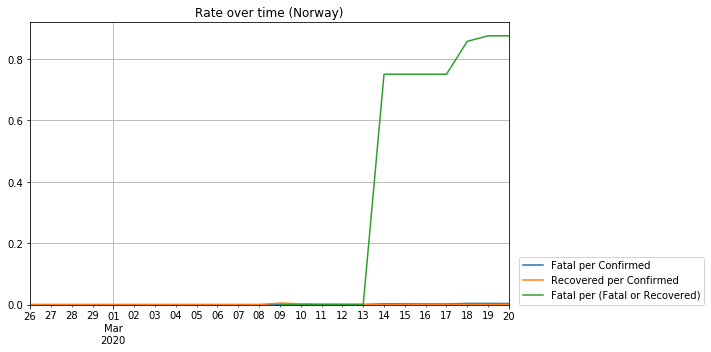

In [18]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [19]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

/Users/adil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

## The SIR epidemic model

A simple mathematical description of the spread of a disease in a population is the so-called SIR model, which divides the (fixed) population of $N$ individuals into three "compartments" which may vary as a function of time, $t$:

 * $S(t)$: Susceptible       (= All - Confirmed)
 * $I(t)$: Infected          (= Confirmed - Recovered - Deaths)
 * $R(t)$: Recovered or Died (= Recovered + Deaths)
 
 

The SIR model describes the change in the population of each of these compartments in terms of two parameters, $\beta$ and $\gamma$. 

* $\beta$ describes the effective contact rate of the disease: an infected individual comes into contact with $\beta N$ other individuals per unit time (of which the fraction that are susceptible to contracting the disease is $S/N$). 

* $\gamma$ is the mean recovery rate: that is, $1/\gamma$ is the mean period of time during which an infected individual can pass it on.

The differential equations describing this model were first derived by Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]:


$$\frac{dS}{dT}=\frac{-\beta}{N}SI$$

$$\frac{dI}{dT}=\frac{\beta SI}{N}-\gamma I$$

$$\frac{dR}{dT}=\gamma I$$

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

<a href="https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/">Sample code</a>


## Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$$\frac{dx}{dt}= - \rho x y$$  
$$\frac{dy}{dt}= \rho x y - \sigma y$$  
$$\frac{dz}{dt}= \sigma y$$

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

In [20]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 83520]


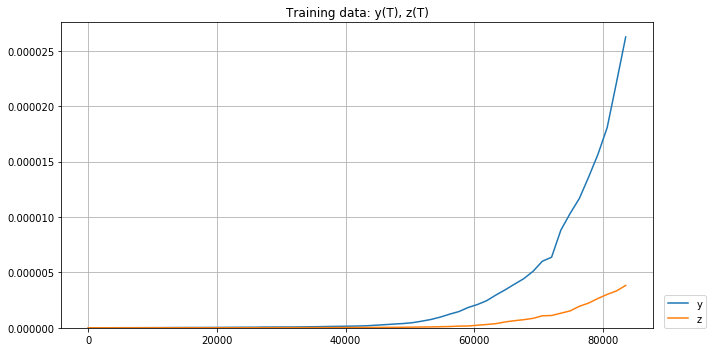

In [21]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [22]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [23]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 6.47 ms, sys: 1.62 ms, total: 8.09 ms
Wall time: 6.64 ms


,t,x,y,z
296,296,0.108567,0.000636,0.890797
297,297,0.108554,0.000600,0.890846
298,298,0.108541,0.000566,0.890893
299,299,0.108529,0.000534,0.890937
300,300,0.108518,0.000504,0.890978


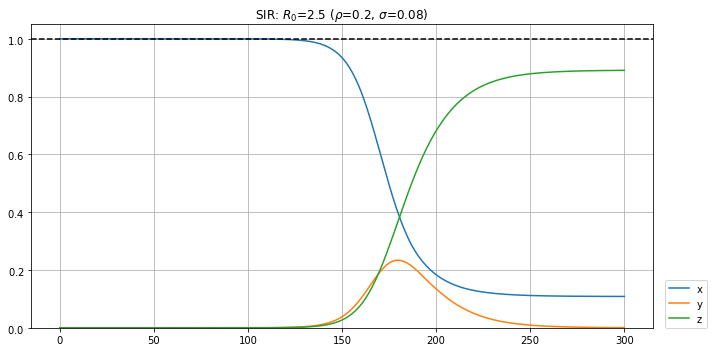

In [24]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [25]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-03-21 18:49:57,296] Finished trial#7 resulted in value: 9569870791.38122. Current best value is 9569870791.38122 with parameters: {'tau': 819, 'rho': 0.08743375342469771, 'sigma': 0.008279293301865387}.
[I 2020-03-21 18:49:57,414] Finished trial#1 resulted in value: 9791682589.084404. Current best value is 9569870791.38122 with parameters: {'tau': 819, 'rho': 0.08743375342469771, 'sigma': 0.008279293301865387}.
[I 2020-03-21 18:49:57,417] Finished trial#5 resulted in value: 31236423347.180508. Current best value is 9569870791.38122 with parameters: {'tau': 819, 'rho': 0.08743375342469771, 'sigma': 0.008279293301865387}.
[I 2020-03-21 18:49:57,535] Finished trial#4 resulted in value: 13893513567.163448. Current best value is 9569870791.38122 with parameters: {'tau': 819, 'rho': 0.08743375342469771, 'sigma': 0.008279293301865387}.
[I 2020-03-21 18:49:57,602] Finished trial#9 resulted in value: 10028808110.86828. Current best value is 9569870791.38122 with parameters: {'tau': 819,

[I 2020-03-21 18:50:00,265] Finished trial#39 resulted in value: 6739106577.342016. Current best value is 6104981756.051215 with parameters: {'tau': 1422, 'rho': 0.1876991616604882, 'sigma': 0.025030439063997184}.
[I 2020-03-21 18:50:00,432] Finished trial#44 resulted in value: 18862728775.833355. Current best value is 6104981756.051215 with parameters: {'tau': 1422, 'rho': 0.1876991616604882, 'sigma': 0.025030439063997184}.
[I 2020-03-21 18:50:00,510] Finished trial#48 resulted in value: 7760566935.681528. Current best value is 6104981756.051215 with parameters: {'tau': 1422, 'rho': 0.1876991616604882, 'sigma': 0.025030439063997184}.
[I 2020-03-21 18:50:00,604] Finished trial#38 resulted in value: 26343456597.87206. Current best value is 6104981756.051215 with parameters: {'tau': 1422, 'rho': 0.1876991616604882, 'sigma': 0.025030439063997184}.
[I 2020-03-21 18:50:00,681] Finished trial#47 resulted in value: 34050076195.363903. Current best value is 6104981756.051215 with parameters: {

[I 2020-03-21 18:50:03,855] Finished trial#78 resulted in value: 10709913514.607382. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:03,943] Finished trial#75 resulted in value: 10455328792.834496. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:04,058] Finished trial#77 resulted in value: 10644067101.07648. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:04,157] Finished trial#76 resulted in value: 9902367870.560331. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:04,298] Finished trial#85 resulted in value: 6136374715.50843. Current best value is 5555138547.507455 with parameters

[I 2020-03-21 18:50:07,390] Finished trial#112 resulted in value: 6372383867.512702. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:07,463] Finished trial#114 resulted in value: 6126745452.379083. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:07,541] Finished trial#115 resulted in value: 6123136899.81717. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:07,679] Finished trial#118 resulted in value: 6645452388.012898. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:07,802] Finished trial#122 resulted in value: 6086276255.754782. Current best value is 5555138547.507455 with paramet

[I 2020-03-21 18:50:11,324] Finished trial#152 resulted in value: 6525848458.59715. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:11,407] Finished trial#154 resulted in value: 5972429169.850645. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:11,492] Finished trial#153 resulted in value: 8217770978.897779. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:11,615] Finished trial#155 resulted in value: 6084987875.955758. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:11,714] Finished trial#136 resulted in value: 10152912319.668814. Current best value is 5555138547.507455 with parame

[I 2020-03-21 18:50:15,082] Finished trial#170 resulted in value: 9106839315.055317. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:15,193] Finished trial#190 resulted in value: 6076270814.53197. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:15,273] Finished trial#191 resulted in value: 6299328465.577617. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:15,375] Finished trial#192 resulted in value: 6162803388.226657. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:15,474] Finished trial#149 resulted in value: 32170529272.744045. Current best value is 5555138547.507455 with parame

[I 2020-03-21 18:50:19,124] Finished trial#226 resulted in value: 6054037347.454301. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:19,268] Finished trial#227 resulted in value: 6052350007.164524. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:19,376] Finished trial#228 resulted in value: 6052521640.391504. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:19,478] Finished trial#229 resulted in value: 6055440543.810758. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:19,654] Finished trial#230 resulted in value: 6128433259.70828. Current best value is 5555138547.507455 with paramet

[I 2020-03-21 18:50:23,275] Finished trial#257 resulted in value: 6986141359.905568. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:23,365] Finished trial#259 resulted in value: 6443397595.742056. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:23,523] Finished trial#207 resulted in value: 17269251875.53101. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:23,676] Finished trial#263 resulted in value: 6692336031.749115. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:23,777] Finished trial#266 resulted in value: 6051305074.077672. Current best value is 5555138547.507455 with parame

[I 2020-03-21 18:50:27,415] Finished trial#300 resulted in value: 6480179585.940235. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:27,511] Finished trial#298 resulted in value: 7104820430.396224. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:27,848] Finished trial#255 resulted in value: 9250898984.649734. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:28,016] Finished trial#303 resulted in value: 7158903801.945313. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:28,265] Finished trial#273 resulted in value: 15219259306.004282. Current best value is 5555138547.507455 with param

[I 2020-03-21 18:50:32,810] Finished trial#335 resulted in value: 6045683092.031048. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:32,907] Finished trial#333 resulted in value: 6762530107.4077425. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:33,102] Finished trial#337 resulted in value: 6046411548.543226. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:33,183] Finished trial#321 resulted in value: 8714755707.307146. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:33,279] Finished trial#338 resulted in value: 6046873962.793391. Current best value is 5555138547.507455 with param

[I 2020-03-21 18:50:37,260] Finished trial#357 resulted in value: 6477914874.390157. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:37,359] Finished trial#368 resulted in value: 5966845702.208323. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:37,454] Finished trial#369 resulted in value: 5994259034.211234. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:37,649] Finished trial#371 resulted in value: 6021139013.747835. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:37,778] Finished trial#374 resulted in value: 6380039681.957401. Current best value is 5555138547.507455 with parame

[I 2020-03-21 18:50:42,213] Finished trial#400 resulted in value: 6243636184.981135. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:42,323] Finished trial#405 resulted in value: 7219206621.708945. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:42,496] Finished trial#408 resulted in value: 6594571429.56477. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:42,599] Finished trial#409 resulted in value: 7106496187.661277. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:42,704] Finished trial#407 resulted in value: 6886801386.022522. Current best value is 5555138547.507455 with paramet

[I 2020-03-21 18:50:46,937] Finished trial#440 resulted in value: 6475953251.647542. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:47,039] Finished trial#431 resulted in value: 8259538321.929023. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:47,193] Finished trial#443 resulted in value: 6083070030.5197735. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:47,353] Finished trial#444 resulted in value: 6093452471.30614. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:47,466] Finished trial#430 resulted in value: 9331381215.840706. Current best value is 5555138547.507455 with parame

[I 2020-03-21 18:50:51,613] Finished trial#476 resulted in value: 6065952745.476879. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:51,767] Finished trial#478 resulted in value: 6192599754.695868. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:51,871] Finished trial#479 resulted in value: 7490492235.065465. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:51,981] Finished trial#477 resulted in value: 6063677044.99167. Current best value is 5555138547.507455 with parameters: {'tau': 36, 'rho': 0.004823814778213818, 'sigma': 0.0006407227950880189}.
[I 2020-03-21 18:50:52,108] Finished trial#480 resulted in value: 6938881130.472304. Current best value is 5555138547.507455 with paramet

CPU times: user 58.3 s, sys: 5.67 s, total: 1min 3s
Wall time: 58.4 s


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



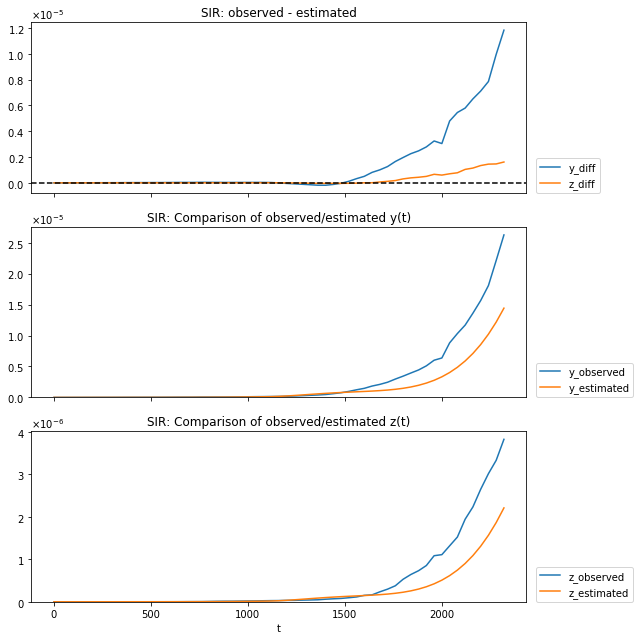

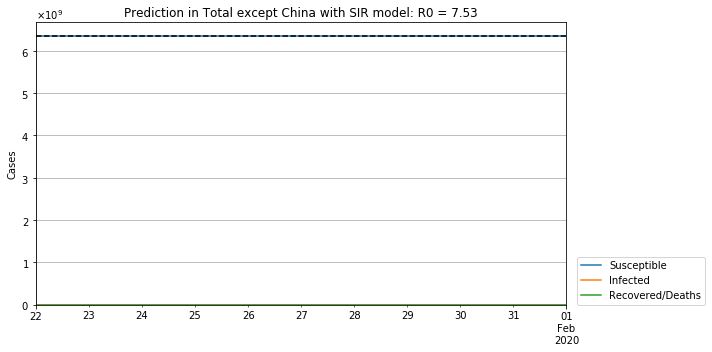

In [26]:
sir_estimater.history_df().head()
#sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [27]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-03-21 18:50:56,873] Finished trial#5 resulted in value: 119324498992.42926. Current best value is 119324498992.42926 with parameters: {'tau': 1067, 'kappa': 0.00046364558364649214, 'rho': 0.10300086411707565, 'sigma': 0.00893851004885152}.
[I 2020-03-21 18:50:57,139] Finished trial#6 resulted in value: 114204123127.83914. Current best value is 114204123127.83914 with parameters: {'tau': 1201, 'kappa': 0.0013670438791197831, 'rho': 0.12292923338524954, 'sigma': 0.011652882143244631}.
[I 2020-03-21 18:50:57,140] Finished trial#7 resulted in value: 117846586055.2705. Current best value is 114204123127.83914 with parameters: {'tau': 1201, 'kappa': 0.0013670438791197831, 'rho': 0.12292923338524954, 'sigma': 0.011652882143244631}.
[I 2020-03-21 18:50:57,252] Finished trial#4 resulted in value: 114939818727.69838. Current best value is 114204123127.83914 with parameters: {'tau': 1201, 'kappa': 0.0013670438791197831, 'rho': 0.12292923338524954, 'sigma': 0.011652882143244631}.
[I 2020-0

[I 2020-03-21 18:50:59,558] Finished trial#37 resulted in value: 85627285151.42354. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:50:59,636] Finished trial#33 resulted in value: 101286704987.6888. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:50:59,701] Finished trial#38 resulted in value: 98590190149.8291. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:50:59,771] Finished trial#30 resulted in value: 80876477268.59798. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:50:59,84

[I 2020-03-21 18:51:02,702] Finished trial#59 resulted in value: 113396494141.49814. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:51:02,868] Finished trial#72 resulted in value: 65777707188.05148. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:51:02,970] Finished trial#65 resulted in value: 81081014888.63548. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:51:03,067] Finished trial#73 resulted in value: 68051775113.98454. Current best value is 64914700896.88723 with parameters: {'tau': 1434, 'kappa': 0.00312347208369139, 'rho': 0.19186275881281814, 'sigma': 0.01938007352457368}.
[I 2020-03-21 18:51:03,

[I 2020-03-21 18:51:06,421] Finished trial#99 resulted in value: 75293483321.10365. Current best value is 64236114541.07125 with parameters: {'tau': 1439, 'kappa': 0.002554622899928604, 'rho': 0.19060025789076102, 'sigma': 0.01944935759294623}.
[I 2020-03-21 18:51:06,521] Finished trial#105 resulted in value: 64881128091.11328. Current best value is 64236114541.07125 with parameters: {'tau': 1439, 'kappa': 0.002554622899928604, 'rho': 0.19060025789076102, 'sigma': 0.01944935759294623}.
[I 2020-03-21 18:51:06,615] Finished trial#103 resulted in value: 82372175254.738. Current best value is 64236114541.07125 with parameters: {'tau': 1439, 'kappa': 0.002554622899928604, 'rho': 0.19060025789076102, 'sigma': 0.01944935759294623}.
[I 2020-03-21 18:51:06,703] Finished trial#104 resulted in value: 82289084376.32492. Current best value is 64236114541.07125 with parameters: {'tau': 1439, 'kappa': 0.002554622899928604, 'rho': 0.19060025789076102, 'sigma': 0.01944935759294623}.
[I 2020-03-21 18:51

[I 2020-03-21 18:51:09,426] Finished trial#135 resulted in value: 100654314128.68587. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:09,556] Finished trial#109 resulted in value: 107345869266.3588. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:09,664] Finished trial#124 resulted in value: 116188225240.99263. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:09,857] Finished trial#136 resulted in value: 108335391208.25902. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 20

[I 2020-03-21 18:51:13,136] Finished trial#165 resulted in value: 81942318161.94298. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:13,220] Finished trial#164 resulted in value: 84307117616.07008. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:13,354] Finished trial#169 resulted in value: 81632363323.36646. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-03-21 18:51:13,454] Finished trial#166 resulted in value: 82149260741.6189. Current best value is 63471499053.72955 with parameters: {'tau': 1404, 'kappa': 0.0026336554177315958, 'rho': 0.18901444998078065, 'sigma': 0.018380252222782723}.
[I 2020-0

[I 2020-03-21 18:51:16,495] Finished trial#199 resulted in value: 64075956026.40753. Current best value is 63365812312.33782 with parameters: {'tau': 1406, 'kappa': 0.0025511448485452544, 'rho': 0.19045804393083868, 'sigma': 0.019079161182983827}.
[I 2020-03-21 18:51:16,571] Finished trial#200 resulted in value: 64441282675.414894. Current best value is 63365812312.33782 with parameters: {'tau': 1406, 'kappa': 0.0025511448485452544, 'rho': 0.19045804393083868, 'sigma': 0.019079161182983827}.
[I 2020-03-21 18:51:16,670] Finished trial#201 resulted in value: 64004509484.22793. Current best value is 63365812312.33782 with parameters: {'tau': 1406, 'kappa': 0.0025511448485452544, 'rho': 0.19045804393083868, 'sigma': 0.019079161182983827}.
[I 2020-03-21 18:51:16,838] Finished trial#203 resulted in value: 64088928901.15854. Current best value is 63365812312.33782 with parameters: {'tau': 1406, 'kappa': 0.0025511448485452544, 'rho': 0.19045804393083868, 'sigma': 0.019079161182983827}.
[I 2020

[I 2020-03-21 18:51:21,250] Finished trial#233 resulted in value: 63554482198.33791. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:21,413] Finished trial#235 resulted in value: 64612879655.87563. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:21,561] Finished trial#226 resulted in value: 76619058359.20345. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:21,670] Finished trial#237 resulted in value: 71210561838.14108. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-

[I 2020-03-21 18:51:25,121] Finished trial#263 resulted in value: 63795430388.92157. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:25,212] Finished trial#262 resulted in value: 63815583460.05558. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:25,397] Finished trial#264 resulted in value: 63783747403.90586. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:25,493] Finished trial#265 resulted in value: 64103020460.15525. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-

[I 2020-03-21 18:51:28,925] Finished trial#294 resulted in value: 63480285330.58289. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:29,030] Finished trial#295 resulted in value: 63603303775.523605. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:29,168] Finished trial#297 resulted in value: 63452951035.72281. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:29,326] Finished trial#298 resulted in value: 63834638208.72575. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020

[I 2020-03-21 18:51:33,099] Finished trial#327 resulted in value: 69111295213.90126. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:33,303] Finished trial#330 resulted in value: 91893781219.05351. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:33,450] Finished trial#331 resulted in value: 79359670223.55449. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:33,601] Finished trial#307 resulted in value: 110951060281.41508. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020

[I 2020-03-21 18:51:37,539] Finished trial#361 resulted in value: 66863903965.51691. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:37,686] Finished trial#362 resulted in value: 70056412172.2184. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:37,798] Finished trial#363 resulted in value: 73371552841.97784. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:37,927] Finished trial#350 resulted in value: 122367748487.0262. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-0

[I 2020-03-21 18:51:41,607] Finished trial#389 resulted in value: 64425798425.27901. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:41,796] Finished trial#390 resulted in value: 98460629806.19672. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:41,912] Finished trial#391 resulted in value: 72455077572.45166. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:42,080] Finished trial#396 resulted in value: 71803206803.58916. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-

[I 2020-03-21 18:51:45,837] Finished trial#420 resulted in value: 64772746925.117065. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:45,960] Finished trial#421 resulted in value: 66974658423.73758. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:46,086] Finished trial#366 resulted in value: 111815899298.23517. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:46,284] Finished trial#422 resulted in value: 67053033282.91183. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 202

[I 2020-03-21 18:51:50,169] Finished trial#455 resulted in value: 86728484252.3357. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:50,305] Finished trial#457 resulted in value: 66802544313.00121. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:50,464] Finished trial#458 resulted in value: 66031784383.89873. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:50,629] Finished trial#454 resulted in value: 93768187291.80576. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-0

[I 2020-03-21 18:51:55,234] Finished trial#488 resulted in value: 67448244219.76768. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:55,406] Finished trial#490 resulted in value: 71891423582.51189. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:55,612] Finished trial#491 resulted in value: 80456742853.71703. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-03-21 18:51:55,723] Finished trial#492 resulted in value: 81069815835.38844. Current best value is 62589134852.78931 with parameters: {'tau': 1404, 'kappa': 0.0022607436155605795, 'rho': 0.18896742770396105, 'sigma': 0.019481946056723452}.
[I 2020-

CPU times: user 1min 1s, sys: 6.13 s, total: 1min 7s
Wall time: 1min 1s


/Users/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



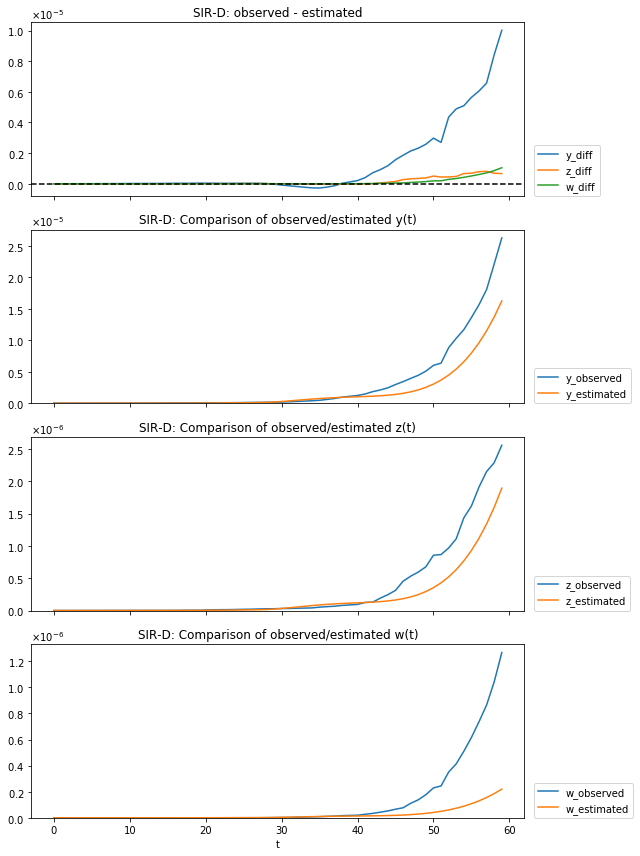

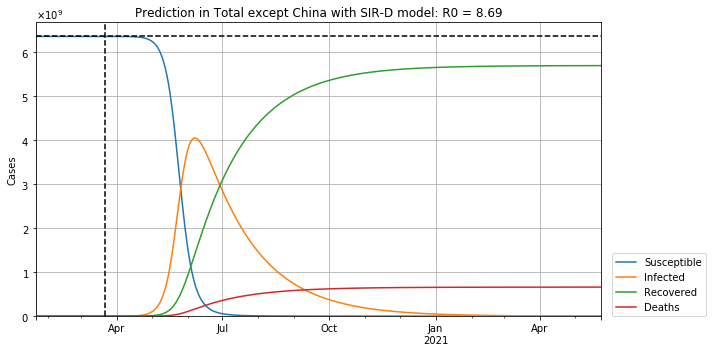

In [28]:
#sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

# References

Further Reading

* M. J. Keeling and P. Rohani, <a href="http://press.princeton.edu/titles/8459.html">Modeling Infectious Diseases in Humans and Animals</a>, Princeton (2007).
* R. M. Anderson and R. M. May, <a href="http://www.amazon.co.uk/Infectious-Diseases-Humans-Dynamics-Publications/dp/019854040X">Infectious Diseases of Humans: Dynamics and Control,</a> OUP (1992).